# Deep Learning Model for Classifying Landscape
###  Patrick Da Silva
* This notebook will walk through the steps from from image collection to deploying the model.
* The model is fed aerial images of rural and suburban landscapes.
* Given novel images, the model will be able to fit the photo into each class accordingly.
* I use an extensive amount of comments in this project to aid in my learning and to make sure I understand exactly what each step is doing.
* This image classification model pipeline was inspired by Nicholas Renotte

## 1 Environment Setup and Data Acquisition

#### Installing Dependencies on Environment

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
#Check to make sure everything installed properly
!pip list

In [1]:
import tensorflow as tf
import os

In [2]:
#Avoid out of memory errors by setting limit on GPU Memory Consumption Growth

#Finding the gpu in my machine (I only have 1, but this would work if you had multiple)
gpus = tf.config.experimental.list_physical_devices('GPU')
#Tensorflow will keep memory usage to the bare minimum
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

#### Remove Corrupt Images 

In [3]:
import cv2
import imghdr #package to check file extensions

In [4]:
data_dir   =  'data'
image_exts = ['jpeg','jpg','bmp','png']

In [5]:
#loop through each folder in data directory (our two classes we want to distinguish between)
for image_class in os.listdir(data_dir):
    #Loop thorugh every image within each class type
    for image in os.listdir(os.path.join(data_dir, image_class)):
        #individual image path
        image_path = os.path.join(data_dir, image_class, image)
        try:
            #make sure image can be read in by OpenCV
            img = cv2.imread(image_path)
            #the extension of each image
            ext = imghdr.what(image_path)
            #if the image extension is not in the preapproved list, delete the image
            if ext not in image_exts:
                print(f'Image not in preapproved extension list {image_path}')
                os.remove(image_path)
        #catch any errors and print out error message
        except Exception as e:
            print(f'ERROR: Issue with image {image_path}')
            # os.remove(image_path) -> only uncomment this if you want to actually want to delete the errors

#### Load Data

In [6]:
import numpy as np
from matplotlib import pyplot as plt

In [7]:
#Step 1: Build data pipeline
#since our data is split into two folders, this function will take care of many preprocessing tasks
# (batch_size = 32, image_size(256,256), shuffle=True, labels='inferred' by DEFAULT)
data = tf.keras.utils.image_dataset_from_directory(data_dir)

#Step 2: Access data pipeline
#Use this to get consecutive batches
data_iterator = data.as_numpy_iterator()

#Step 3: Grab a single batch
#Each batch will have 2 components, 1 - images loaded into memory as np array, 2 - class labels
batch = data_iterator.next()

Found 1391 files belonging to 2 classes.


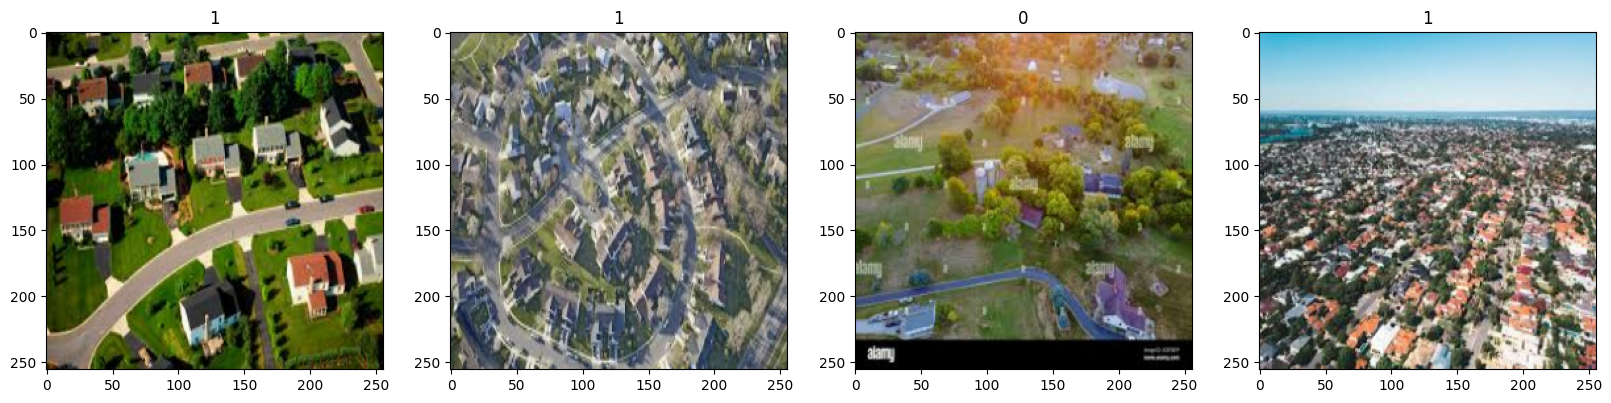

In [8]:
#Print some example images, also figure out which label corresponds to which class - written by Nicholas Renotte
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    
#Rural = 0
#Suburban = 1

## 2 Data Preprocessing

#### Scale Data

In [9]:
#when each batch is loaded, scale the values in the 3 color channels to be between 0 and 1
scaled_data = data.map(lambda x, y: (x/255, y))

#### Split Data

In [10]:
#Split the data into train, validation, and test
#Training data - make the model and learn hidden features
train_size = int(len(scaled_data)*.8)+1 #37 atches of 32 images
#Validation data - validate model performance and tune hyperparameters
val_size   = int(len(scaled_data)*.1) #4 batches of 32 images
#Test data - evaluate model after training is completed
test_size  = int(len(scaled_data)*.1) #4 batches of 32 images

In [11]:
#Data already shuffled - take the values correpsonding to the number of batches for each data set
train = scaled_data.take(train_size) #37 batches of 32 images
val   = scaled_data.skip(train_size).take(val_size) #4 batches of 32 images
test  = scaled_data.skip(train_size+val_size).take(test_size) # 4 batches of 32 images

## 3 Deep Model

#### Build Keras Sequential Deep Learning Model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, InputLayer

In [13]:
model = Sequential()

### Start Preprocessing/Data Augmentation ###
model.add(InputLayer(input_shape=(256,256,3)))
#Horizontal flip is unlikely to influence our image, therefore we apply this transformation to effectively train on more images
model.add(preprocessing.RandomFlip('horizontal')) # flip left to right
### End Preprocessing/Data Augmentation ###

### Start Base/Convolution/Feature Extraction ###
#First Block
#Start with larger kernel for dimensionality reduction
model.add(BatchNormalization())
model.add(Conv2D(16, (5,5), 1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=1, padding='same'))
#Second Block
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), 1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=1, padding='same'))
#Third Block
model.add(Conv2D(16, (3,3), 1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=1, padding='same'))
### End Base/Convolution/Feature Extraction ###

### Start Head/Classification ###
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(units=256, activation='relu'))
#Add dropout to help prevent overfitting
model.add(Dropout(rate=0.3))
model.add(BatchNormalization())
model.add(Dense(units=1, activation='sigmoid'))
### End Head/Classification ###

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #optimizer - adjusts the weights to minimize the loss (adam is a SGD optimizer with an adaptive learning rate
    loss='binary_crossentropy', #loss - compares the predicted probability  with the actual output then calculates error based on the distance from the expected value
    metrics=['accuracy'], #metrics - how well the model is classifying data
)

#### Train Model

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
#Stop training when validation loss starts to increase
early_stopping = EarlyStopping(
    min_delta=0.01,  #minimum amount of change to count as improvement
    patience=10,     #how many epochs to wait before stopping
    restore_best_weights=True,
)

In [16]:
#For Reproducability
tf.random.set_seed(31415)
np.random.seed(31415)
history = model.fit(
    train,               #training dataset - #28 batches of 32 images
    validation_data=val, #validation dataset - #3 batches of 32 images
    epochs=100,           #number of runs through entire training dataset
    callbacks=[early_stopping],
)

Epoch 1/100
36/36 [==============================] - 12s 232ms/step - loss: 0.5805 - accuracy: 0.8359 - val_loss: 1.9688 - val_accuracy: 0.4531
Epoch 2/100
36/36 [==============================] - 8s 201ms/step - loss: 0.2142 - accuracy: 0.9141 - val_loss: 3.1124 - val_accuracy: 0.4141
Epoch 3/100
36/36 [==============================] - 8s 202ms/step - loss: 0.1332 - accuracy: 0.9488 - val_loss: 3.5564 - val_accuracy: 0.4297
Epoch 4/100
36/36 [==============================] - 8s 201ms/step - loss: 0.0804 - accuracy: 0.9757 - val_loss: 4.1104 - val_accuracy: 0.4219
Epoch 5/100
36/36 [==============================] - 8s 203ms/step - loss: 0.0577 - accuracy: 0.9826 - val_loss: 3.6973 - val_accuracy: 0.4844
Epoch 6/100
36/36 [==============================] - 8s 209ms/step - loss: 0.0397 - accuracy: 0.9931 - val_loss: 3.0512 - val_accuracy: 0.5547
Epoch 7/100
36/36 [==============================] - 8s 212ms/step - loss: 0.0337 - accuracy: 0.9905 - val_loss: 3.8864 - val_accuracy: 0.367

#### Plot Performance

In [17]:
#The model displayed layer by layer with several metrics
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 16)     0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 256, 256, 16)     64        
 hNormalization)                                                 
                                                        

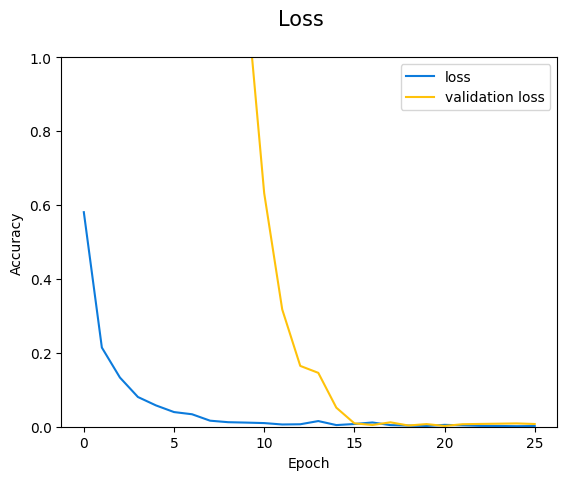

In [18]:
#Plotting loss and validation loss across epochs
loss_eval = plt.figure()
plt.ylim(0,1)
plt.plot(history.history['loss'], color='#0C7BDC', label='loss')
plt.plot(history.history['val_loss'], color='#FFC20A', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
loss_eval.suptitle('Loss', fontsize=15)
plt.legend(loc='upper right')
plt.show()

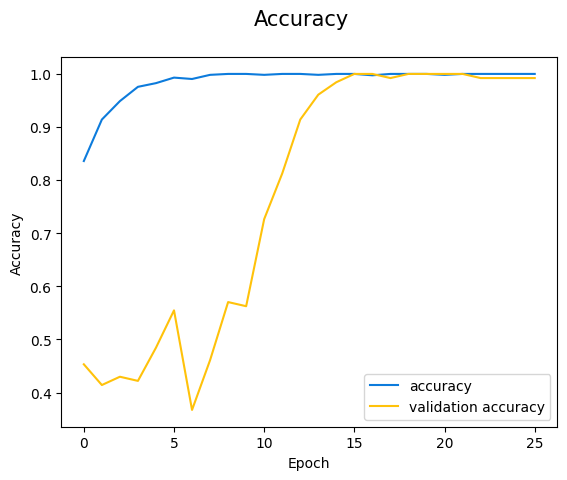

In [19]:
#Plotting accuracy and validation accuracy across epcohs
acc_eval = plt.figure()
plt.plot(history.history['accuracy'], color='#0C7BDC', label='accuracy')
plt.plot(history.history['val_accuracy'], color='#FFC20A', label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
acc_eval.suptitle('Accuracy', fontsize=15)
plt.legend(loc='lower right')
plt.show()

## 4 Evaluate Performance

#### Evaluate

In [20]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [21]:
#establish instances of the metrics
precision    = Precision()      # (TruePos)/(TruePos+FalsePos) -> model's ability to calssify something as positive
recall       = Recall()         # (TruePos)/(TruePos+FalseNeg) -> model's ability to detect positive samples
binAccuracy  = BinaryAccuracy() # (TruePos + TrueNeg)/all -> number of correct predictions divided by all predictions

In [22]:
#loop through each batch in the testing dataset - 3 batches with 32 images each
for batch in test.as_numpy_iterator():
    #X is the images, y is the true value of 1s and 0s
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat) 
    recall.update_state(y, yhat)    
    binAccuracy.update_state(y,yhat)

1/1 [==============================] - 0s 235ms/step


In [23]:
print(f'Precision = {precision.result()}')
print(f'Recall = {recall.result()}')
print(f'Binary Accuracy = {binAccuracy.result()}')

Precision = 1.0
Recall = 0.9682539701461792
Binary Accuracy = 0.9819819927215576


#### Showing Off: Visualizing Testing with Single Images Outside of Dataset

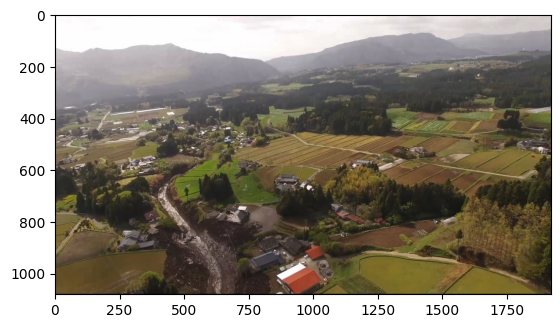

In [38]:
#Show off model by testing on a single image outside of dataset
#Load image
image = cv2.imread('RTest4.jpg')
#Switch color values from BGR to RGB
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [39]:
resize = tf.image.resize(image, (256,256))
#predict class with the model
yhat = model.predict(np.expand_dims(resize/255, 0))
#The value yhat is the probability of a certain class by the model. Closer to 0 means more likely RURAL, and closer to 1 means more likely SUBURBAN
print(f'yhat = {yhat}')

1/1 [==============================] - 0s 16ms/step
yhat = [[0.07593416]]


In [40]:
#Display which class the model chose for the image
if yhat > 0.5:
    print('Predicted class is Suburban')
else:
    print('Predicted class is Rural')

Predicted class is Rural


## 5 Save Model for Future Use

In [41]:
model.save(os.path.join('models','landscapeClass.h5'))

## 6 Conclusions

#### Model Evaluation
 - The model completed the classifying task with flying colors! All three of our metrics are as good as they could be on our testing data. <br> 
    - Recall that -> *Precision = 1.0, Recall = 0.968, Binary Accuracy = 0.982*

#### Limitations
- The dataset was compiled from a quick google search, therefore our model is likely not as robust as it could be.
    - For example, rural images with gridlike crops tend to confuse the model

#### Questions/Concerns
- The model has 272 million total parameters, 2 million of which are untrainable (It seems the number of parameters is unusually large). I will investigate why this is the case and improve the model accordingly.
<br>
- Both validation loss and validation accuracy started very far away from the training loss and training accuracy, but quickly converged.

#### Future Direction
1. Implement categorical classification with other landscapes (cities, desserts, oceans, forests, etc.)
2. Integrate with a video feed to allow real time updates of landscape
3. This model can also be improved by reducing the number of parameters while keeping the Precision, Recall, and Accuracy high. Reduce running cost and time
    